In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import re
from haversine import haversine, Unit
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# Data pre-processing

In [8]:
dfTrain = pd.read_csv("prepared_data/apartments_and_building_train.csv")
dfTest = pd.read_csv("prepared_data/apartments_and_building_test.csv")

In [9]:
def get_distance_center(lat1, lon1):
    dist = haversine((lat1, lon1), (55.751244, 37.618423), unit=Unit.METERS)
    return round(dist/1000, 3)

def get_shortest_distance(lat, lon, coordinates):
    shortest = np.inf
    for coord in coordinates:
        dist = haversine(coord, (lat, lon), unit=Unit.METERS)
        if dist < shortest:
            shortest = dist
    if shortest == np.inf:
        return 100
    return round(shortest/1000, 3)

Distance to center

In [13]:
dfTrain["distance_center"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)
dfTest["distance_center"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)

Metro stations

In [15]:
def add_distance_to(target, df_train, df_test):
    targets = pd.read_csv(f"prepared_data/extra_features/{target}.csv")
    coordinates = targets.values.tolist()

    df_train[f"distance_{target}"] = df_train.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)
    df_test[f"distance_{target}"] = df_test.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)

""" positive """
add_distance_to("metro", dfTrain, dfTest)
add_distance_to("university", dfTrain, dfTest)
add_distance_to("shopping_center", dfTrain, dfTest)
add_distance_to("park", dfTrain, dfTest)
add_distance_to("golf_course", dfTrain, dfTest)
""" negative """
add_distance_to("airport", dfTrain, dfTest)
add_distance_to("prison", dfTrain, dfTest)

In [49]:
def process_data(dataframe, keep_col):
    """ columns = ['building_id', 'id_x', 'id_y', 'seller', 'price', 'area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 
            'condition', 'phones', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 
            'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'parking', 'garbage_chute', 'heating', 'distance_center', 'distance_metro',
            'distance_university', 'distance_shopping_center', 'distance_park', 'distance_golf_course', 
            'distance_airport', 'distance_prison'] """

    remove_columns = ['street', 'address', 'building_id', 'id_y', 'id_x', 'price']

    # 'distance_university', 'distance_shopping_center', 'distance_park', 'distance_golf_course', 'distance_airport', 'distance_prison'
   
    for col in keep_col:
        remove_columns.remove(col)

    dataframe = dataframe.drop(remove_columns, axis=1)
    
            
    """
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']
    for column in dataframe.columns.values:
        
        if(column in fill_mode):
            #print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
            
     fill_mean=['area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'phones', 'new', 'latitude', 'longitude',
            'constructed', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'garbage_chute', 'distance_center', 'distance_metro']
    
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']

    for column in dataframe.columns.values:
        #Finding the mean of the column having NaN
        mean_value=dataframe[column].mean()
        dataframe[column].fillna(value=mean_value, inplace=True)
    
        if(column in fill_mean):
            print("Filling "+column+" with mean")
            mean_value=dataframe[column].mean()
            dataframe[column].fillna(value=mean_value, inplace=True)
            
        if(column in fill_mode):
            print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
    """

    return dataframe

# LGBMRegression

C:\Users\erikm\AppData\Local\Temp/ipykernel_25612/2302921986.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0
Test RMSLE: 0.131


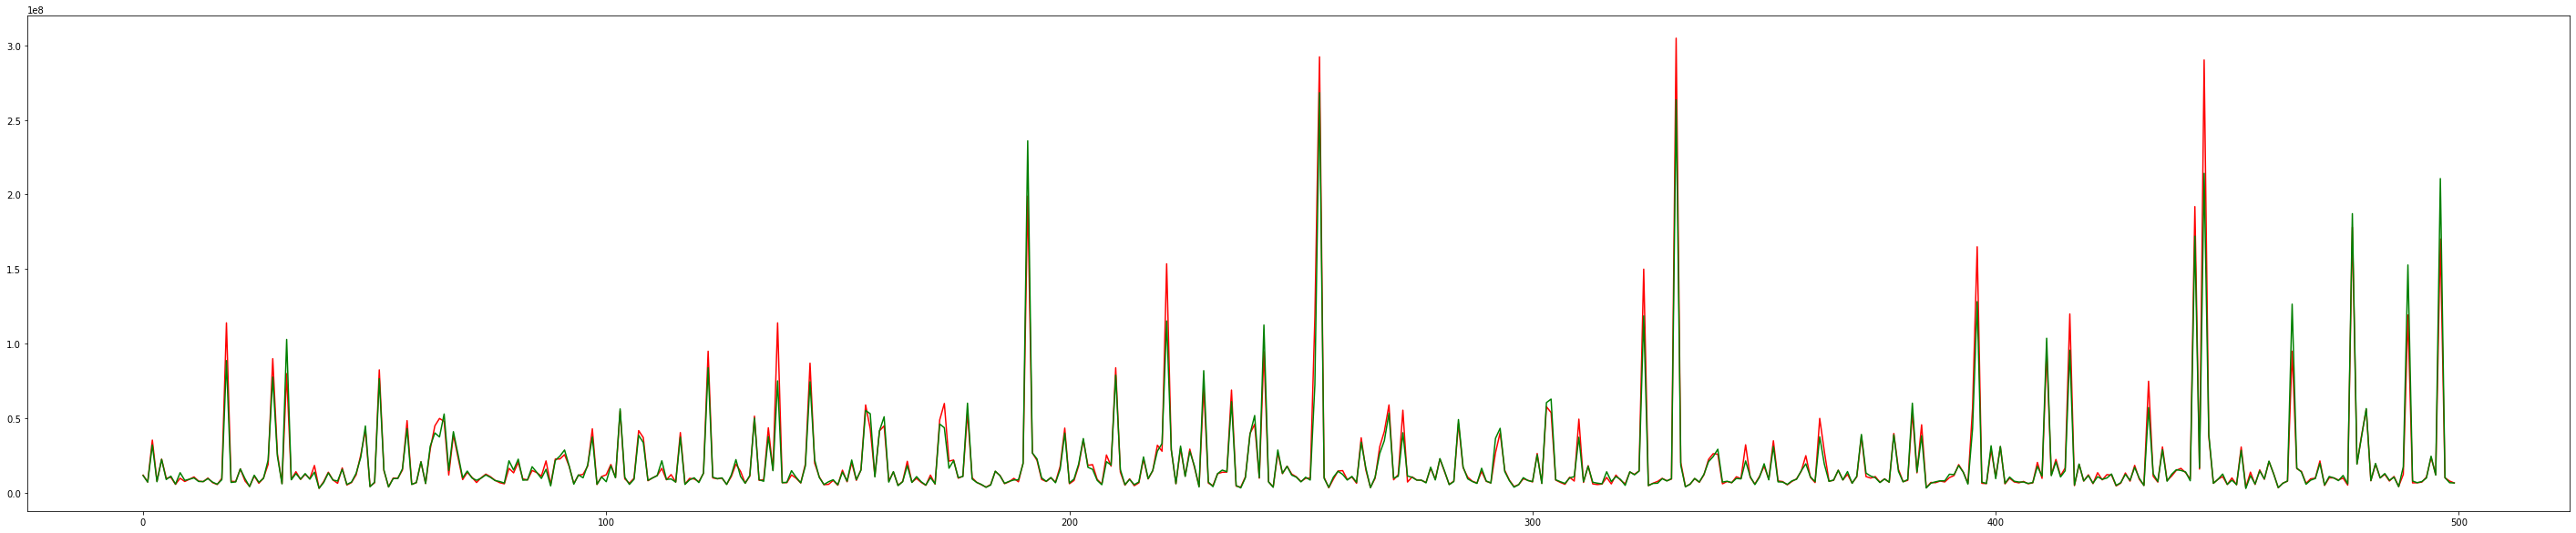

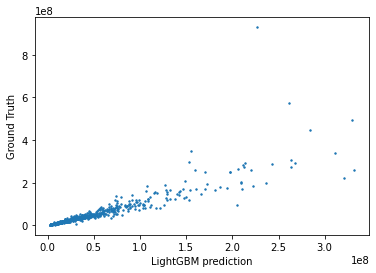

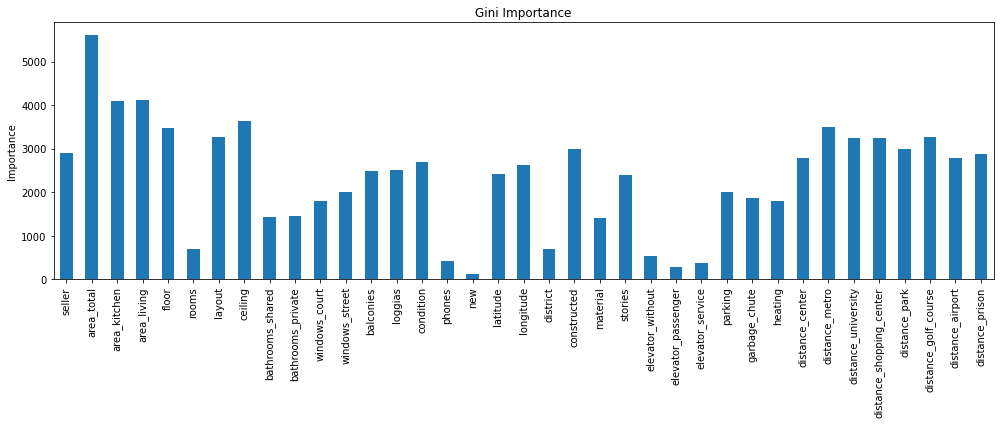

In [40]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=30,
    max_depth=10, 
    random_state=42,
    metric='rmse',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.7,
    subsample=0.9,
    learning_rate=0.05
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


lgbm_regressor.fit(X_train, y_train)

lgbm_prediction = lgbm_regressor.predict(X_test)
lgbm_prediction = np.exp(lgbm_prediction)

faulty_rows = []
for i in range(len(lgbm_prediction)):
    if lgbm_prediction[i] < 900000:
        lgbm_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

lgbm_rmsle = round(np.sqrt(mean_squared_log_error(lgbm_prediction, y_test)), 3)
print('Test RMSLE:', lgbm_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(lgbm_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(lgbm_prediction, y_test, s=2)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')
plt.show()

importances = lgbm_regressor.feature_importances_
forest_importances = pd.Series(importances, index=cols)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# 0.154 
# 0.139 log
# 0.131 log + all_features + rmsle
# 0.131 log + all_features + rmse
# 0.132 log + all_features-(prison, airport)
# 0.132 log + all_features + keep_high_prices

In [51]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
lgbm_predictions = lgbm_regressor.predict(test_data)
lgbm_predictions = np.exp(lgbm_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(lgbm_predictions)):
    if lgbm_predictions[i] < 900000:
        lgbm_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = lgbm_predictions
submission.to_csv("lgbm_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# XGBoost

In [35]:
n_estimators=[100, 500, 900, 1100, 1500]
max_depth=[2, 3, 5, 10, 15]
booster=['gbtree', 'gblinear']
learning_rate=[0.025, 0.05, 0.1, 0.15, 0.20]
min_child_weight=[1, 2, 3, 4, 5]
base_score=[0.25, 0.5, 0.75, 1]


hyperparameter_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'base_score': base_score
    
}

C:\Users\erikm\AppData\Local\Temp/ipykernel_25612/865442649.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[22:35:56] WARNING: ..\src\learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0
Test RMSLE: 0.13


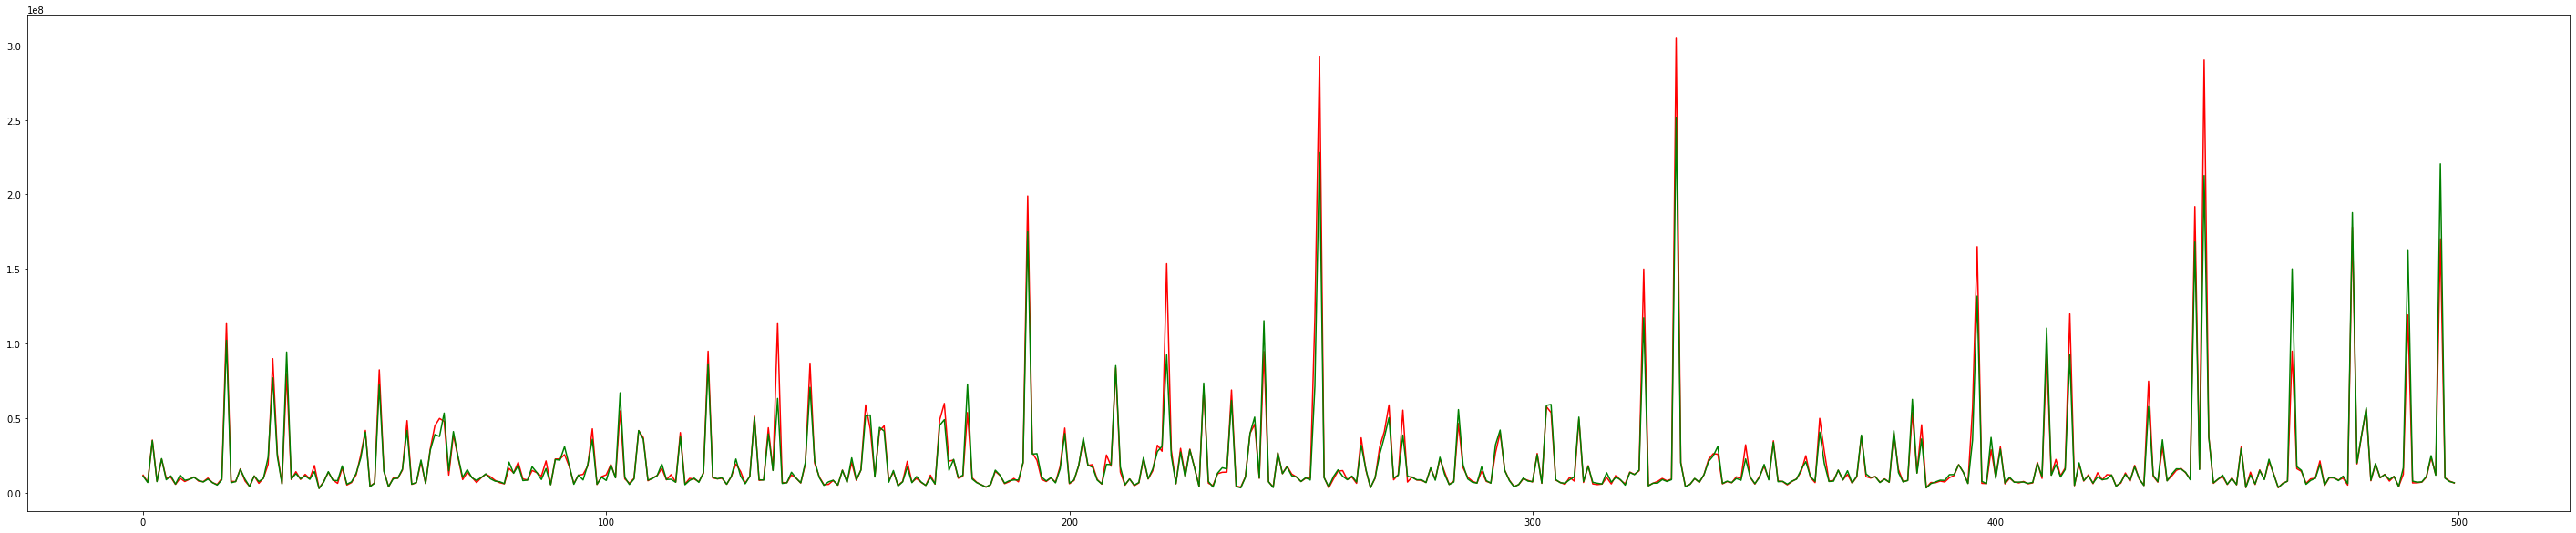

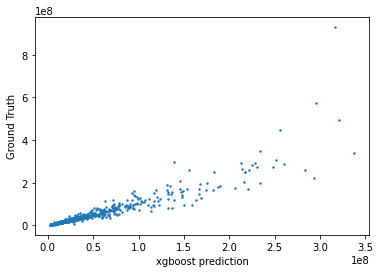

In [46]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# log prices
y_train = np.log(y_train)

scaler = preprocessing.StandardScaler().fit(X_train)

imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


"""
classifier=xgboost.XGBRegressor()

random_cv=RandomizedSearchCV(estimator=classifier, 
                             param_distributions=hyperparameter_grid, 
                             cv=5, 
                             scoring='neg_mean_absolute_error',
                             n_jobs=4,
                             verbose=5,
                             return_train_score=True,
                             random_state=42
                            )
random_cv.fit(X_train, y_train)
random_cv.best_estimator_
"""
xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None, objective='reg:squarederror')


xgboost_regressor.fit(X_train, y_train)

xgboost_prediction = xgboost_regressor.predict(X_test)
xgboost_prediction = np.exp(xgboost_prediction)


faulty_rows = []
for i in range(len(xgboost_prediction)):
    if xgboost_prediction[i] < 900000:
        xgboost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

xgboost_rmsle = round(np.sqrt(mean_squared_log_error(xgboost_prediction, y_test)), 3)
print('Test RMSLE:', xgboost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(xgboost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(xgboost_prediction, y_test, s=2)
plt.xlabel('xgboost prediction')
plt.ylabel('Ground Truth')
plt.show()

# 0.144
# 0.138 log
# 0.130 log + all_features
# 0.130 log + all_features + rmse


In [52]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
xgboost_predictions = xgboost_regressor.predict(test_data)
xgboost_predictions = np.exp(xgboost_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(xgboost_predictions)):
    if xgboost_predictions[i] < 900000:
        xgboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("xgboost_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 # Catboost

C:\Users\erikm\AppData\Local\Temp/ipykernel_25612/1187126122.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0
Test RMSLE: 0.142


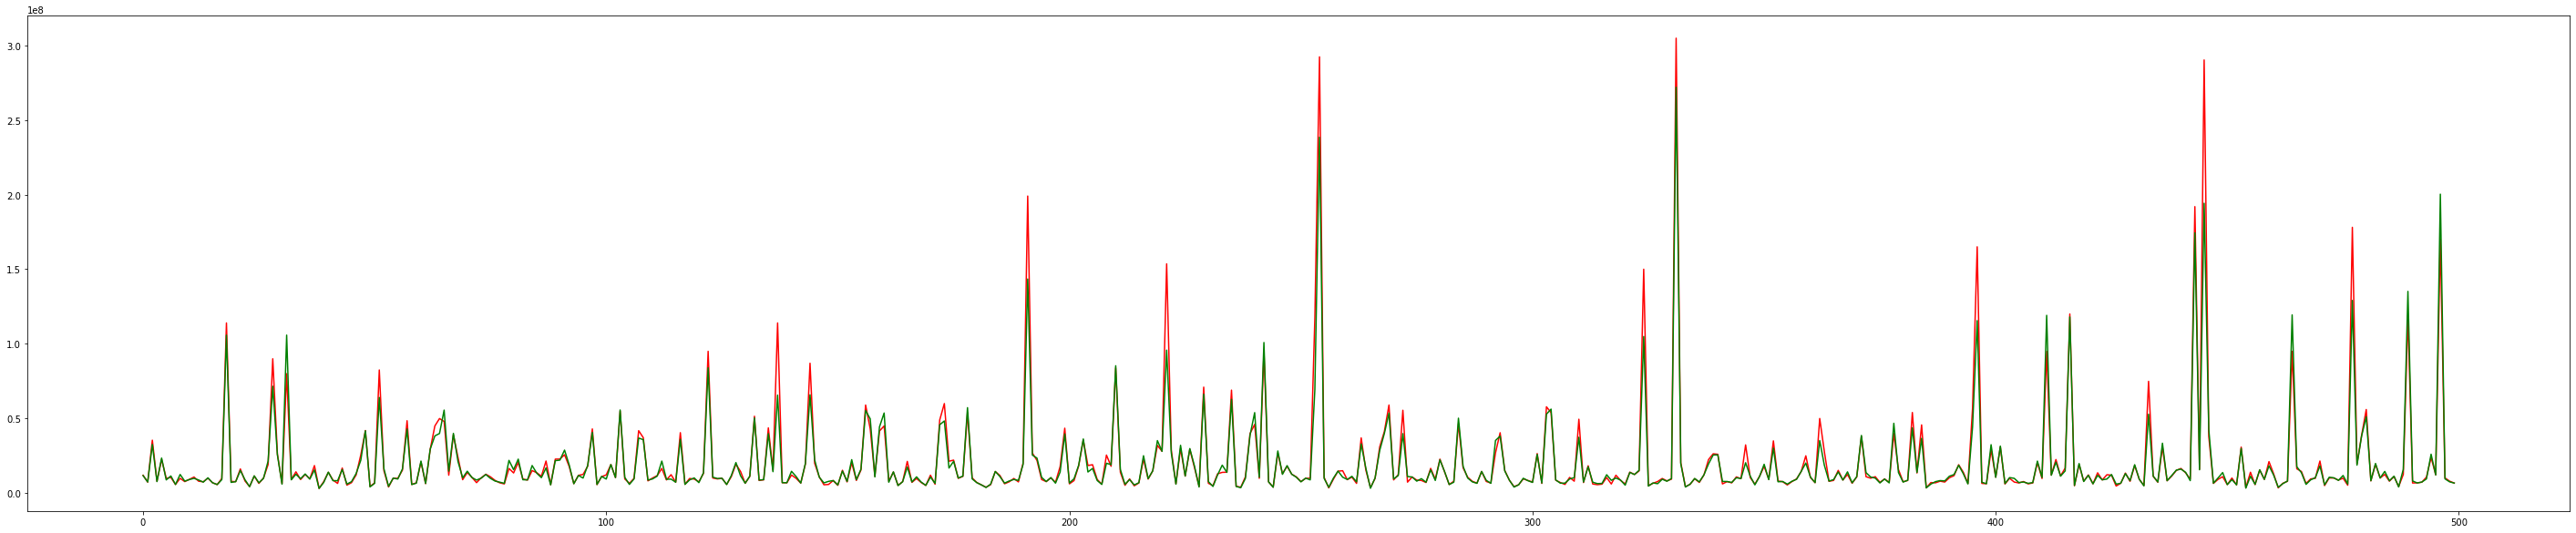

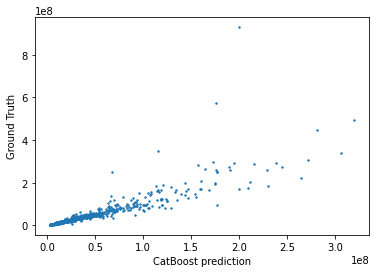

In [47]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# log prices
y_train = np.log(y_train)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5
)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)



catboost_regressor = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    thread_count=-1,
    depth=12,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

#cat_features=['seller', 'condition', 'district','material','heating', 'parking']

catboost_regressor.fit(X_train, y_train)

cat_boost_prediction = catboost_regressor.predict(X_test)
cat_boost_prediction = np.exp(cat_boost_prediction)

faulty_rows = []
for i in range(len(cat_boost_prediction)):
    if cat_boost_prediction[i] < 900000:
        cat_boost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

cat_boost_rmsle = round(np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test)), 3)
print('Test RMSLE:', cat_boost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(cat_boost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(cat_boost_prediction, y_test, s=2)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')
plt.show()

# 0.170
# 0.142 log + all_features

In [53]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
catboost_predictions = catboost_regressor.predict(test_data)
catboost_predictions = np.exp(catboost_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(catboost_predictions)):
    if catboost_predictions[i] < 900000:
        catboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("catboost_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Stacking

In [54]:
acc = pd.DataFrame(
    {'LightGBM':     lgbm_rmsle,
     'XGBoost':      xgboost_rmsle,
     'CatBoost':     cat_boost_rmsle},
    index=[0]
)
acc = acc.T
acc.columns = ['MSE']
acc

,MSE
LightGBM,0.131
XGBoost,0.130
CatBoost,0.142


# Simple averaging

Test MSE: 0.126


Text(0, 0.5, 'Ground Truth')

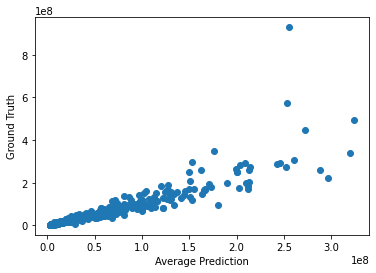

In [70]:
avg_predictions = np.average(
    [lgbm_prediction,
     xgboost_prediction,
     cat_boost_prediction
    ],
    weights = 1 / acc['MSE'] ** 5,
    axis=0
)


print('Test MSE:', round(np.sqrt(mean_squared_log_error(avg_predictions, y_test)), 3))

plt.scatter(avg_predictions, y_test)
plt.xlabel('Average Prediction')
plt.ylabel('Ground Truth')

In [27]:
# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  avg_predictions
submission.to_csv("average_predictions.csv", index=False)

# True Stacking

### First Step

In [222]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])


scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)


X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)



<ipython-input-222-ed88c09e46e1>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [223]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data)


In [224]:
ntrain = X_train.shape[0]
ntest = test_data.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [225]:
lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=100,
    max_depth=10, 
    random_state=42,
    metric='rmsle',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


catboost_regressor = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    thread_count=-1,
    depth=10,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [226]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
print('All preictions for train set:', len(dt_oof_train))
print('All preictions for test set:', len(dt_oof_test))

All preictions for train set: 20935
All preictions for test set: 9937


In [228]:
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train, y_train, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train, y_train, test_data)

### Second Step

In [229]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [230]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05
)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7, metric='mse',
              n_estimators=200, n_jobs=4, num_leaves=5, random_state=42,
              subsample=0.9)

In [231]:
final_predictions = META_MODEL.predict(x_test)

In [232]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)

In [203]:
cat_mse = round(mean_squared_log_error(final_predictions, y_test), 2)
print('Test MSE:', cat_mse)

Test MSE: 0.02


Text(0, 0.5, 'Ground Truth')

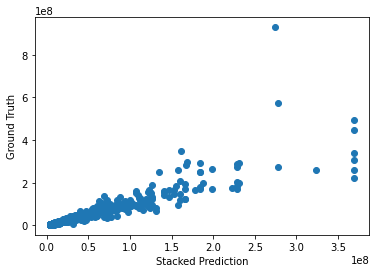

In [208]:
plt.scatter(final_predictions, y_test)
plt.xlabel('Stacked Prediction')
plt.ylabel('Ground Truth')

In [ ]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)